In [1]:
dataset=3
from utils.get_dataset_info import get_dataset_info
import cv2 as cv
import numpy as np
from utils import general, pflat, estimate_T_robust, levenberg_marquardt, triangulate_3D_point_DLT, viz
from romatch import roma_outdoor
import torch
import os
from tqdm import tqdm

bf = cv.BFMatcher(normType=cv.NORM_L2, crossCheck=False)

K, img_names, init_pair, pixel_threshold = get_dataset_info(dataset)
K_inv = np.linalg.inv(K)

# Ensure directories exist for this dataset
os.makedirs(f"./storage/{dataset}", exist_ok=True)

# Load images
image_paths = ['./project_data/'+img_name for img_name in img_names]

# Normalize pixel threshold
focal_length = (K[0,0] + K[1 ,1])/2 # Average over the diagonal
epipolar_treshold      =     pixel_threshold / focal_length
homography_threshold   = 3 * pixel_threshold / focal_length
translation_threshold  = 3 * pixel_threshold / focal_length

# Initialize RoMa model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
roma_model = roma_outdoor(device=device)

# Initialize reference frames
reference_imA_path = image_paths[init_pair[0]-1]
reference_imB_path = image_paths[init_pair[1]-1]

/home/davnords/python-envs/main/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/davnords/python-envs/main/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using coarse resolution (560, 560), and upsample res (864, 864)


In [81]:
X = np.random.randn(3, 1000)
x = np.random.randn(3, 1000)
R = np.eye(3)
t = np.zeros((3,1))

In [139]:
# Test bundle adjustment


P = np.hstack((R, t))

proj = R@X + t
proj = proj/proj[-1]
r = (proj-x)[:2, :].reshape(-1, 1)

N = X.shape[-1]
c = (R[2, :]@X).flatten()+t[-1]

J1 = np.hstack((
    1 / c,
    np.zeros((N))
))
J2 = np.hstack((
    np.zeros((N)),
    1 / c,
))
J3 = np.hstack((
    -(R[0, :]@X+t[0])/c,
    -(R[1, :]@X+t[1])/c,
))

# Rotation parametrized as R = (I+(a1*S1+a2*S2+a3*S3))@R0

S1 = np.array([
    [0, -1, 0],
    [1, 0, 0],
    [0, 0, 0]
])

S2 = np.array([
    [0, 0, -1],
    [0, 0, 0],
    [1, 0, 0]
])

S3 = np.array([
    [0, 0, 0],
    [0, 0, -1],
    [0, 1, 0]
])

S = np.stack((S1, S2, S3))

J4 = np.hstack((
    (S1[0, :]@R@X)/c-((R[0,:]@X+t[0])/(c**2))*(S1[2, :]@R@X),
    (S1[1, :]@R@X)/c-((R[1,:]@X+t[1])/(c**2))*(S1[2, :]@R@X),
))

J5 = np.hstack((
    (S2[0, :]@R@X)/c-((R[0,:]@X+t[0])/(c**2))*(S2[2, :]@R@X),
    (S2[1, :]@R@X)/c-((R[1,:]@X+t[1])/(c**2))*(S2[2, :]@R@X),
))

J6 = np.hstack((
    (S3[0, :]@R@X)/c-((R[0,:]@X+t[0])/(c**2))*(S3[2, :]@R@X),
    (S3[1, :]@R@X)/c-((R[1,:]@X+t[1])/(c**2))*(S3[2, :]@R@X),
))

J = np.vstack((J1, J2, J3, J4, J5, J6)).T

mu=100

delta = -np.linalg.inv(J.T@J+mu*np.eye(6))@J.T @r
delta_t = delta[:3]
a = delta[3:6]
error = (r**2).sum().item()

# Update step
R = (np.eye(3)+(a[0]*S1+a[1]*S2+a[2]*S3))@R
t += delta_t

print('Error: ', error)


Error:  2022.7974579874362


In [2]:
import cv2
def find_relative_rotations(image_paths, K_inv, model, eps, device='cuda:0'):
    out = []
    for i in range(len(image_paths)-1):
        imA_path = image_paths[i]
        imB_path = image_paths[i+1]
        x1n, x2n = general.find_matches(imA_path, imB_path, model, K_inv, device=device)

        # E, mask = cv2.findEssentialMat(
        #     x1n[:2].T, x2n[:2].T, 
        #     cameraMatrix=np.eye(3),  # Identity since points are normalized
        #     method=cv2.RANSAC,
        #     prob=0.999,
        #     threshold=eps
        # ) 
        # _, R, t, _ = cv2.recoverPose(E, x1n[:2].T, x2n[:2].T)
        
        R = general.parallell_RANSAC(x1n, x2n, eps, iterations=100)[:3, :3]
        out.append(R)
    return out

def upgrade_to_absolute_rotations(relative_rotations):
    """
    Upgrade relative rotations to absolute rotations.
    
    Parameters:
    - relative_rotations: List of 3x3 relative rotation matrices.
    
    Returns:
    - absolute_rotations: List of 3x3 absolute rotation matrices.
    """
    absolute_rotations = [np.eye(3)]  # First camera is the global reference frame
    for R_rel in relative_rotations:
        # Compute the absolute rotation by chaining the previous absolute rotation with the relative rotation
        absolute_rotations.append(absolute_rotations[-1] @ R_rel)
    
    return absolute_rotations

In [3]:
relative_rotations = find_relative_rotations(image_paths, K_inv, roma_model, epipolar_treshold, device=device)
absolute_rotations = upgrade_to_absolute_rotations(relative_rotations)

RANSAC iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.46it/s]


After running RANSAC for 100 iterations the best solution has 8880 inliers of 10000 points. I.e. c. 88.80%


RANSAC iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.38it/s]


After running RANSAC for 100 iterations the best solution has 9453 inliers of 10000 points. I.e. c. 94.53%


RANSAC iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.45it/s]


After running RANSAC for 100 iterations the best solution has 6325 inliers of 10000 points. I.e. c. 63.25%


RANSAC iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.66it/s]


After running RANSAC for 100 iterations the best solution has 4068 inliers of 10000 points. I.e. c. 40.68%


RANSAC iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.62it/s]


After running RANSAC for 100 iterations the best solution has 5120 inliers of 10000 points. I.e. c. 51.20%


RANSAC iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.62it/s]


After running RANSAC for 100 iterations the best solution has 8721 inliers of 10000 points. I.e. c. 87.21%


RANSAC iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.46it/s]


After running RANSAC for 100 iterations the best solution has 3082 inliers of 10000 points. I.e. c. 30.82%


RANSAC iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.56it/s]


After running RANSAC for 100 iterations the best solution has 7760 inliers of 10000 points. I.e. c. 77.60%


RANSAC iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.60it/s]


After running RANSAC for 100 iterations the best solution has 9053 inliers of 10000 points. I.e. c. 90.53%


RANSAC iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.48it/s]


After running RANSAC for 100 iterations the best solution has 2658 inliers of 10000 points. I.e. c. 26.58%


RANSAC iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.62it/s]

After running RANSAC for 100 iterations the best solution has 3054 inliers of 10000 points. I.e. c. 30.54%


In [4]:
import cv2
def match_3d_to_image(X, descX, image_path):
    kp_new, desc_new = sift.detectAndCompute(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), None)
    matches = bf.knnMatch(descX, desc_new, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    X_indices = [m.queryIdx for m in good_matches]
    image_points = np.float32([kp_new[m.trainIdx].pt for m in good_matches])
    matched_3d_points = X[:, X_indices]

    return matched_3d_points, image_points

In [5]:
from utils.estimate_E_robust import estimate_E_robust
from utils.extract_P_from_E import extract_P_from_E
from utils.triangulate_3D_point_DLT import triangulate_3D_point_DLT


def triangulate_initial_points(x1n, x2n, eps, R_rel):
    T_rel = np.array([1, 0, 0])
    
    E, _ = estimate_E_robust(x1n, x2n, eps, iterations=100)

    #  E, mask = cv2.findEssentialMat(
    #     x1n[:2].T, x2n[:2].T, 
    #     cameraMatrix=np.eye(3),  # Identity since points are normalized
    #     method=cv2.RANSAC,
    #     prob=0.999,
    #     threshold=eps
    # ) 
    # _, R, t, _ = cv2.recoverPose(E, x1n[:2].T, x2n[:2].T)
    

    P1 = np.hstack((np.eye(3), np.zeros((3,1))))
    P2s = extract_P_from_E(E)

    xn = np.array([x1n, x2n])

    N = x1n.shape[-1]
    
    Xjs = []
    depth_counts = []
    for P2 in tqdm(P2s, desc='Triangulating points...'):
        Xj = []
        positive_depth_count = 0
        for i in range(N):
            xi = xn[:, :, i]
            Xi, _ = triangulate_3D_point_DLT(xi[0, :2], xi[1, :2], P1, P2)
            Xj.append(Xi)

            X_h = np.hstack((Xi, [1]))  # Homogeneous coordinates
            if P1[2, :] @ X_h > 0 and P2[2, :] @ X_h > 0:
                positive_depth_count += 1
        Xj = np.array(Xj)
        Xjs.append(Xj)
        depth_counts.append(positive_depth_count)
    
    depth_counts = np.array(depth_counts)
    highest_depth_count = np.argmax(depth_counts)
    return Xjs[highest_depth_count]

In [6]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img1 = cv.imread(reference_imA_path,cv.IMREAD_GRAYSCALE)    # queryImage
img2 = cv.imread(reference_imB_path,cv.IMREAD_GRAYSCALE)    # trainImage

# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

x1u = general.make_homogenous(np.float32([kp1[m.queryIdx].pt for m in good]))  # Points from first image
x2u = general.make_homogenous(np.float32([kp2[m.trainIdx].pt for m in good]))  # Points from second image
x1n, x2n = pflat.pflat(K_inv@x1u), pflat.pflat(K_inv@x2u)

# Get the descriptors corresponding ONLY to the matched points
good_indices = [m.queryIdx for m in good]
descX = des1[good_indices]  # These descriptors now correspond to the points we triangulated

R_rel = absolute_rotations[init_pair[1]-1] @ absolute_rotations[init_pair[0]-1].T 

X0 = triangulate_initial_points(x1n, x2n, epipolar_treshold, R_rel)
X0 = X0.T
R_ref_to_world = absolute_rotations[init_pair[0]-1][:3, :3]
X0 = R_ref_to_world@X0
X, indices = general.remove_3D_outliers(X0.T)
X = X.T
descX = descX[indices]

RANSAC iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.83it/s]


After running RANSAC for 100 iterations the best solution has 1084 inliers of 9763 points. I.e. c. 11.10%


Triangulating points...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.15it/s]


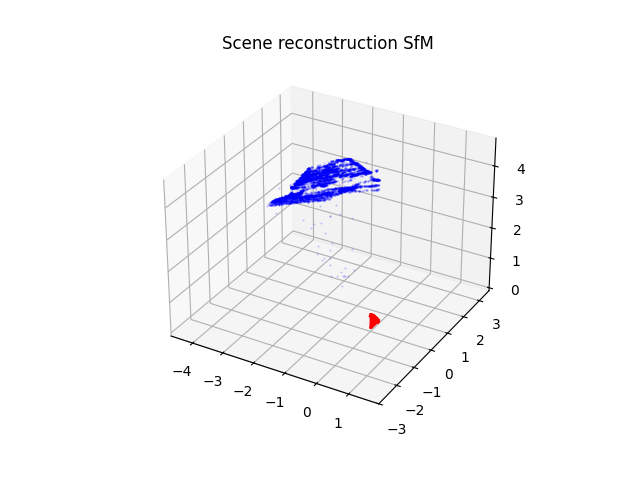

In [7]:
%matplotlib widget
viz.plot_scene_old(X.T, [np.hstack((R, np.zeros((3,1)))) for R in absolute_rotations])

In [8]:
Ps = []
xs = []
Xs = []
from utils.estimate_T_robust import estimate_T_robust
for i in range(len(image_paths)):
    R = absolute_rotations[i]

    objectPoints, imagePoints = match_3d_to_image(X, descX, image_paths[i])

    # rvec, _ = cv2.Rodrigues(R)
    # success, rvec, T, inliers = cv2.solvePnPRansac(objectPoints.T, imagePoints, K, None, rvec=rvec, useExtrinsicGuess=True)
    # R_new, _ = cv2.Rodrigues(rvec)

    # Ps.append(np.hstack((R, T)))
    x2n = pflat.pflat(K_inv@general.make_homogenous(imagePoints))
    Ps.append(estimate_T_robust(x2n, general.make_homogenous(objectPoints.T), R, translation_threshold, iterations=500))
    xs.append(x2n)
    Xs.append(objectPoints)

    

RANSAC iterations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 7553.00it/s]


After running RANSAC for 500 iterations the best solution has 2211 inliers of 3958 points. I.e. c. 55.86%


RANSAC iterations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 6995.78it/s]


After running RANSAC for 500 iterations the best solution has 2637 inliers of 4570 points. I.e. c. 57.70%


RANSAC iterations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 6657.16it/s]


After running RANSAC for 500 iterations the best solution has 3032 inliers of 4987 points. I.e. c. 60.80%


RANSAC iterations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 5990.29it/s]


After running RANSAC for 500 iterations the best solution has 3427 inliers of 5830 points. I.e. c. 58.78%


RANSAC iterations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 4734.49it/s]


After running RANSAC for 500 iterations the best solution has 5153 inliers of 8787 points. I.e. c. 58.64%


RANSAC iterations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 5793.32it/s]


After running RANSAC for 500 iterations the best solution has 3686 inliers of 6252 points. I.e. c. 58.96%


RANSAC iterations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 5774.07it/s]


After running RANSAC for 500 iterations the best solution has 3550 inliers of 6205 points. I.e. c. 57.21%


RANSAC iterations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 5098.49it/s]


After running RANSAC for 500 iterations the best solution has 4483 inliers of 8268 points. I.e. c. 54.22%


RANSAC iterations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 6188.06it/s]


After running RANSAC for 500 iterations the best solution has 2696 inliers of 5336 points. I.e. c. 50.52%


RANSAC iterations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 6705.97it/s]


After running RANSAC for 500 iterations the best solution has 2356 inliers of 4813 points. I.e. c. 48.95%


RANSAC iterations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 7185.79it/s]


After running RANSAC for 500 iterations the best solution has 1980 inliers of 4331 points. I.e. c. 45.72%


RANSAC iterations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 7838.91it/s]

After running RANSAC for 500 iterations the best solution has 1747 inliers of 3738 points. I.e. c. 46.74%


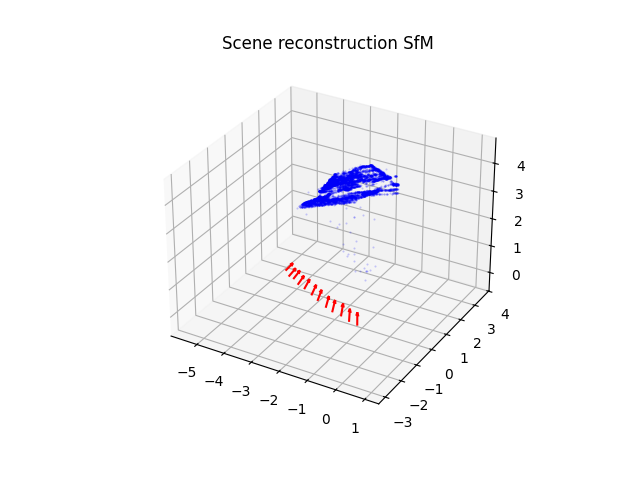

In [14]:
%matplotlib widget
viz.plot_scene_old(X.T, Ps)

In [10]:
import numpy as np
from tqdm import tqdm

def perform_bundle_adjustment(Xs, xs, Ps, epochs=5, mu=0.1):
    """
    Perform bundle adjustment for multiple cameras and 3D points.

    Args:
        Xs (list of np.ndarray): List of 3D points, each of shape (3, n_points).
        xs (list of np.ndarray): List of observed 2D homogenous points, each of shape (3, n_points).
        Ps (list of np.ndarray): List of camera projection matrices, each of shape (3, 4).
        epochs (int): Number of optimization iterations.
        mu (float): Damping parameter for Levenberg-Marquardt.

    Returns:
        list of np.ndarray: Optimized projection matrices.
    """
    for epoch in tqdm(range(epochs), desc='Performing Bundle Adjustment...'):
        errors = []
        for i, (P, x, X) in enumerate(zip(Ps, xs, Xs)):
            R, t = P[:3, :3], P[:, 3].reshape(-1, 1)
            proj = R@X + t
            proj = proj/proj[-1, :]
            r = (proj-x)[:2, :].reshape(-1, 1)

            N = X.shape[-1]
            c = (R[2, :]@X).flatten()+t[-1]

            J1 = np.hstack((
                1 / c,
                np.zeros((N))
            ))
            J2 = np.hstack((
                np.zeros((N)),
                1 / c,
            ))
            J3 = np.hstack((
                -(R[0, :]@X+t[0])/c,
                -(R[1, :]@X+t[1])/c,
            ))
            J = np.vstack((J1, J2, J3)).T

            delta_t = -np.linalg.inv(J.T @J+mu*np.eye(3))@J.T @r
            errors.append((r**2).sum().item())

            Ps[i][:, 3] += delta_t.flatten()

        print(f"Full reprojection error in epoch {epoch + 1}/{epochs} is: {np.sum(errors):.4f}")

    return Ps

In [13]:
Ps = perform_bundle_adjustment(Xs, xs, Ps, mu=10)

Performing Bundle Adjustment...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 319.08it/s]

Full reprojection error in epoch 1/5 is: 161.4702
Full reprojection error in epoch 2/5 is: 161.4664
Full reprojection error in epoch 3/5 is: 161.4650
Full reprojection error in epoch 4/5 is: 161.4646
Full reprojection error in epoch 5/5 is: 161.4647


In [16]:
def triangulate_scene(image_paths, Ps, roma_model, K_inv, device='cuda:0'):
    X = []
    for i in tqdm(range(len(image_paths)-1), desc='Performing triangulation...'):
        imA_path = image_paths[i]
        imB_path = image_paths[i+1]

        P1 = Ps[i]
        P2 = Ps[i+1]

        x1n, x2n = general.find_matches(imA_path, imB_path, roma_model, K_inv, device=device)
        for j in range(x1n.shape[-1]):
            Xi, _ = triangulate_3D_point_DLT(x1n[:2, j], x2n[:2, j], P1, P2)
            X.append(Xi)
    
    X = np.array(X)
    return X

In [17]:
X = triangulate_scene(image_paths, Ps, roma_model, K_inv, device='cuda:0')

Performing triangulation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.02s/it]


In [23]:
X.shape

(110000, 3)

In [ ]:
def perform_bundle_adjustment_points(X, xs, Ps, epochs=5, mu=0.1):
    pass
    

In [28]:
Ps_tensor = np.array(Ps)
Xh = general.make_homogenous(X)
Ps_tensor.shape
proj = (Ps_tensor@Xh)
xs[0].shape

(3, 3952)

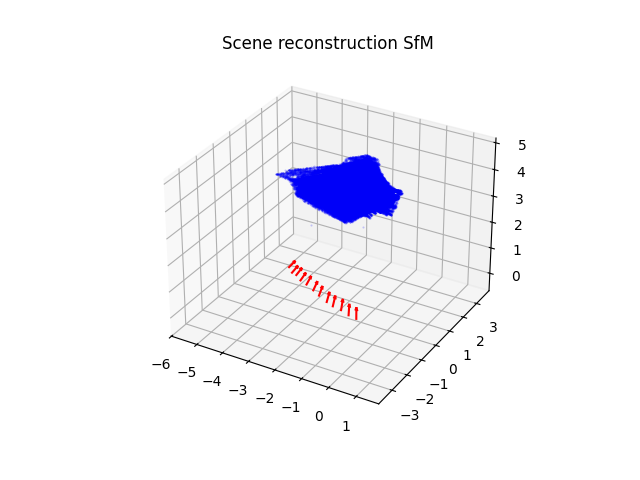

In [18]:
viz.plot_scene_old(X, Ps)